# [作業目標]
- 使用 Day 17 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 17 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # 另一個繪圖-樣式套件


# 忽略警告訊息
import warnings
warnings.filterwarnings('ignore')
# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取資料檔
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 17 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [5]:
#找出與年齡有關的相關函數
print('負相關 top 15',app_train.corr()['DAYS_BIRTH'].sort_values().head(15))
print('正相關 top 15',app_train.corr()['DAYS_BIRTH'].sort_values(ascending=False).head(15))

負相關 top 15 FLAG_EMP_PHONE               -0.619888
DAYS_EMPLOYED                -0.352321
DAYS_REGISTRATION            -0.331912
CNT_CHILDREN                 -0.330938
CNT_FAM_MEMBERS              -0.278894
DAYS_ID_PUBLISH              -0.272691
REG_CITY_NOT_WORK_CITY       -0.242401
REG_CITY_NOT_LIVE_CITY       -0.180382
FLAG_WORK_PHONE              -0.172457
LIVE_CITY_NOT_WORK_CITY      -0.158882
FLAG_OWN_CAR                 -0.129879
FLAG_DOCUMENT_8              -0.113243
FLAG_DOCUMENT_3              -0.109666
REG_REGION_NOT_WORK_REGION   -0.095819
HOUR_APPR_PROCESS_START      -0.091064
Name: DAYS_BIRTH, dtype: float64
正相關 top 15 DAYS_BIRTH                    1.000000
DAYS_EMPLOYED_ANOM            0.619947
EXT_SOURCE_1                  0.600610
FLAG_DOCUMENT_6               0.407160
EXT_SOURCE_3                  0.205478
FLAG_OWN_REALTY               0.119146
EXT_SOURCE_2                  0.091996
AMT_REQ_CREDIT_BUREAU_YEAR    0.071983
AMT_CREDIT                    0.055436
AMT_GOODS

In [7]:
#觀察TARGET 年齡與FLAG_OWN_CAR的關係

app_train['FLAG_OWN_CAR'].fillna(0)#缺值補0
age_data = app_train[['TARGET','FLAG_OWN_CAR', 'DAYS_BIRTH']] # subset
age_data['YEARS_BIRTH'] = abs(age_data['DAYS_BIRTH'])/365

bin_cut = np.linspace(20,70,num=11) 
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = bin_cut) 
# 顯示不同組的數量
print(age_data['YEARS_BINNED'].value_counts())
age_data.head()

(35.0, 40.0]    42868
(40.0, 45.0]    41406
(30.0, 35.0]    39440
(45.0, 50.0]    35135
(50.0, 55.0]    34942
(55.0, 60.0]    33120
(25.0, 30.0]    32862
(60.0, 65.0]    27476
(20.0, 25.0]    12159
(65.0, 70.0]     8103
Name: YEARS_BINNED, dtype: int64


,TARGET,FLAG_OWN_CAR,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,0,9461,25.920548,"(25.0, 30.0]"
1,0,0,16765,45.931507,"(45.0, 50.0]"
2,0,1,19046,52.180822,"(50.0, 55.0]"
3,0,0,19005,52.068493,"(50.0, 55.0]"
4,0,0,19932,54.608219,"(50.0, 55.0]"


In [8]:
test_df= age_data.groupby(['YEARS_BINNED','FLAG_OWN_CAR'])
test_df['TARGET'].describe()

count      mean       std  min  25%  50%  75%  \
YEARS_BINNED FLAG_OWN_CAR                                                    
(20.0, 25.0] 0              8289.0  0.126312  0.332221  0.0  0.0  0.0  0.0   
             1              3870.0  0.116021  0.320291  0.0  0.0  0.0  0.0   
(25.0, 30.0] 0             20300.0  0.123103  0.328564  0.0  0.0  0.0  0.0   
             1             12562.0  0.092581  0.289856  0.0  0.0  0.0  0.0   
(30.0, 35.0] 0             23292.0  0.115963  0.320187  0.0  0.0  0.0  0.0   
             1             16148.0  0.083849  0.277170  0.0  0.0  0.0  0.0   
(35.0, 40.0] 0             25475.0  0.098842  0.298456  0.0  0.0  0.0  0.0   
             1             17393.0  0.075605  0.264373  0.0  0.0  0.0  0.0   
(40.0, 45.0] 0             25171.0  0.085614  0.279799  0.0  0.0  0.0  0.0   
             1             16235.0  0.067447  0.250802  0.0  0.0  0.0  0.0   
(45.0, 50.0] 0             22573.0  0.081336  0.273357  0.0  0.0  0.0  0.0   
             1             12562.0  0.061296  0.239882  0.0  0.0  0.0  0.0   
(50.0, 55.0] 0             24093.0  0.069149  0.253712  0.0  0.0  0.0  0.0   
             1             10849.0  0.062126  0.241395  0.0  0.0  0.0  0.0   
(55.0, 60.0] 0             24720.0  0.056270  0.230447  0.0  0.0  0.0  0.0   
             1              8400.0  0.052500  0.223046  0.0  0.0  0.0  0.0   
(60.0, 65.0] 0             22063.0  0.053121  0.224279  0.0  0.0  0.0  0.0   
             1              5413.0  0.051173  0.220371  0.0  0.0  0.0  0.0   
(65.0, 70.0] 0              6948.0  0.037997  0.191202  0.0  0.0  0.0  0.0   
             1              1155.0  0.032900  0.178453  0.0  0.0  0.0  0.0   

                           max  
YEARS_BINNED FLAG_OWN_CAR       
(20.0, 25.0] 0             1.0  
             1             1.0  
(25.0, 30.0] 0             1.0  
             1             1.0  
(30.0, 35.0] 0             1.0  
             1             1.0  
(35.0, 40.0] 0             1.0  
             1             1.0  
(40.0, 45.0] 0             1.0  
             1             1.0  
(45.0, 50.0] 0             1.0  
             1             1.0  
(50.0, 55.0] 0             1.0  
             1             1.0  
(55.0, 60.0] 0             1.0  
             1             1.0  
(60.0, 65.0] 0             1.0  
             1             1.0  
(65.0, 70.0] 0             1.0  
             1             1.0

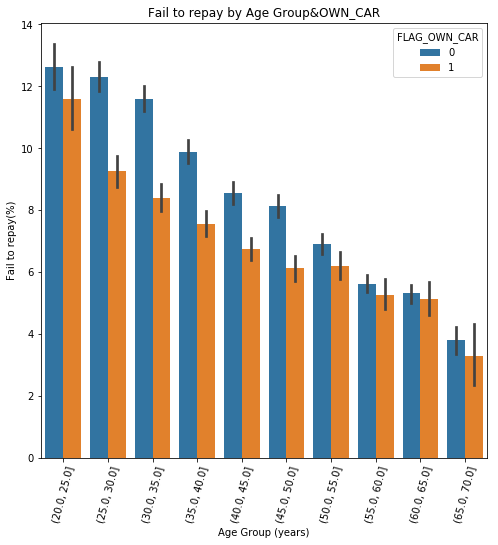

In [11]:
plt.figure(figsize = (8, 8))

# 以年齡區間為 x, target 為 y 繪製 barplot,在加進有無車輛進行分析

px = age_data['YEARS_BINNED']
py = 100*age_data['TARGET']
hue_p= age_data['FLAG_OWN_CAR']
sns.barplot(px, py,hue = hue_p)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Fail to repay(%)')
plt.title('Fail to repay by Age Group&OWN_CAR');

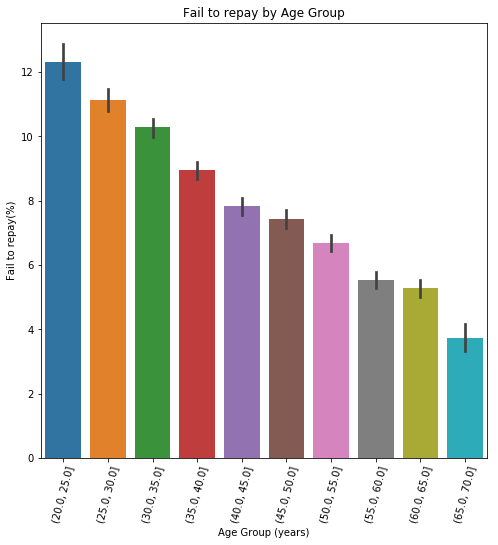

In [12]:
plt.figure(figsize = (8, 8))

# 以年齡區間為 x, target 為 y 繪製 barplot

px = age_data['YEARS_BINNED']
py = 100*age_data['TARGET']
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Fail to repay(%)')
plt.title('Fail to repay by Age Group');

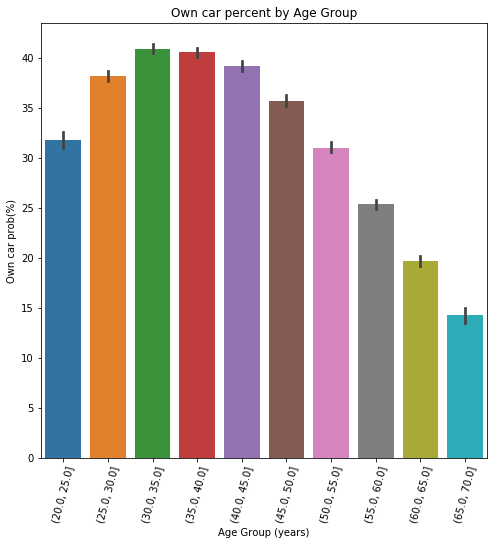

In [13]:
plt.figure(figsize = (8, 8))

# 以年齡區間為 x, target 為 y 繪製 barplot

px = age_data['YEARS_BINNED']
py = 100*age_data['FLAG_OWN_CAR']
sns.barplot(px, py)

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Own car prob(%)')
plt.title('Own car percent by Age Group');